# DistilBERT for Fake News Detection - Unified Training Pipeline

## 1. Introduction

This notebook demonstrates how to fine-tune DistilBERT for fake news detection using our standardized train/validation/test splits. DistilBERT represents a different approach to model compression compared to TinyBERT, using knowledge distillation to retain 97% of BERT's performance while reducing model size by 40% and increasing inference speed by 60%.

DistilBERT achieves this efficiency through a sophisticated distillation process where it learns to mimic BERT's behavior across all layers simultaneously, rather than just the final outputs. With approximately 66 million parameters (about 60% of BERT-base), it strikes an excellent balance between performance and computational efficiency.

### Understanding DistilBERT's Architectural Philosophy

While TinyBERT focuses on aggressive parameter reduction through bottleneck structures, DistilBERT takes a different approach. It maintains BERT's general architecture but reduces the number of layers from 12 to 6, while keeping the hidden dimension size constant at 768. This design choice preserves BERT's representational capacity while significantly reducing computational requirements.

The knowledge distillation process for DistilBERT involves three types of losses: masked language modeling loss (like BERT's pretraining), distillation loss (matching the teacher's output distributions), and cosine embedding loss (aligning hidden state representations). This comprehensive approach allows DistilBERT to capture both the surface patterns and deeper semantic understanding that make BERT effective.

### Why Unified Data Splits Enable Fair Comparison

Using identical train/validation/test splits across all models in our comparison study eliminates a major confounding variable. When researchers use different data splits for different models, they introduce an element of randomness that can significantly affect conclusions. A model might appear superior simply because it received easier test examples, not because of genuine architectural advantages.

By standardizing our data splits, we ensure that performance differences reflect true capabilities. This approach allows us to make confident statements about the trade-offs between model complexity, training time, inference speed, and accuracy. When we later compare DistilBERT's 66 million parameters against TinyBERT's 15 million or against traditional machine learning approaches, we'll know these comparisons are scientifically valid.

## 2. Environment Setup

We'll configure our environment with careful attention to both reproducibility and clean output formatting.

In [1]:
# Import essential libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import PyTorch for deep learning operations
import torch
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Import Hugging Face transformers for pre-trained models and training utilities
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset

2025-06-04 10:30:06.367684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749033006.520631      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749033006.564383      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Import evaluation metrics for comprehensive performance assessment
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Configure environment settings for reproducibility and clean output
def set_seed(seed_value=42):
    """
    Configure all random number generators and environment settings for reproducible results.
    
    This function ensures that every run of our training produces identical results,
    which is crucial for scientific reproducibility and fair model comparison.
    We also configure tokenizer settings to eliminate parallelism warnings.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    # Disable tokenizer parallelism to avoid fork warnings during training
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    
    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True

# Apply our environment configuration
set_seed(42)

Understanding why we disable tokenizer parallelism helps appreciate the complexity of modern machine learning systems. Transformer tokenizers can use multiple CPU cores to process text faster, but this can conflict with PyTorch's own parallelization strategies during training. By explicitly setting single-threaded tokenization, we avoid these conflicts while maintaining clean, professional output.

In [6]:
# Configure visualization settings for clear, informative plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

In [7]:
# Determine computational device and display hardware information
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("Training will proceed on CPU - consider using GPU for faster training")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB


## 3. Loading Standardized Data Splits

Rather than creating our own data divisions, we'll load the carefully prepared splits that ensure fair comparison across all models in our evaluation study.

In [8]:
# Load the standardized data splits for consistent model comparison
print("Loading standardized train/validation/test splits...")

train_df = pd.read_csv('/kaggle/input/welfake-clean-split/train.csv')
val_df = pd.read_csv('/kaggle/input/welfake-clean-split/validation.csv')
test_df = pd.read_csv('/kaggle/input/welfake-clean-split/test.csv')

print(f"Training set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")
print(f"Total articles: {len(train_df) + len(val_df) + len(test_df):,}")

Loading standardized train/validation/test splits...
Training set: 50,075 samples
Validation set: 10,731 samples
Test set: 10,731 samples
Total articles: 71,537


In [9]:
# Verify consistent class distribution across all splits
print("\nClass balance verification:")
for name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    fake_ratio = df['label'].mean()
    real_count = sum(df['label'] == 0)
    fake_count = sum(df['label'] == 1)
    print(f"{name} set: {fake_ratio:.1%} fake news ({real_count:,} real, {fake_count:,} fake)")


Class balance verification:
Train set: 51.0% fake news (24,520 real, 25,555 fake)
Validation set: 51.0% fake news (5,254 real, 5,477 fake)
Test set: 51.0% fake news (5,254 real, 5,477 fake)


The consistent class balance across splits (approximately 51% fake news) ensures that our model encounters the same classification challenge during training, validation, and final testing. This consistency is crucial because class imbalance can significantly affect model behavior, and we want to isolate the effects of architectural differences rather than dataset variations.

In [10]:
# Display sample data to understand text characteristics
print("\nSample articles from training set:")
for i in range(2):
    label_text = "Fake" if train_df.iloc[i]['label'] == 1 else "Real"
    text_preview = train_df.iloc[i]['combined_text'][:150] + "..."
    print(f"\nExample {i+1} ({label_text}): {text_preview}")


Sample articles from training set:

Example 1 (Fake): SWEDISH RESIDENT SPEAKS OUT ABOUT DECADES OF MUSLIM IMMIGRATION: “We all live in the same town, but not in the same world”  The Swedish identity will ...

Example 2 (Real): Russia will keep bases in Syria to strike at insurgents: Kremlin MOSCOW (Reuters) - Russia will keep a naval and an air base in Syria capable of carry...


## 4. Data Preprocessing for DistilBERT

Transformer models require specific text preprocessing that converts raw text into numerical tokens. DistilBERT uses the same tokenizer as BERT, which employs WordPiece tokenization to handle the vast vocabulary of natural language efficiently.

In [11]:
# Convert pandas DataFrames to Hugging Face Dataset format for efficient processing
train_dataset = Dataset.from_pandas(train_df[['combined_text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['combined_text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['combined_text', 'label']])

print("Successfully converted data to Hugging Face Dataset format")
print("This format optimizes memory usage and enables efficient batch processing")

Successfully converted data to Hugging Face Dataset format
This format optimizes memory usage and enables efficient batch processing


In [12]:
# Load DistilBERT tokenizer with identical vocabulary to BERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

print("DistilBERT tokenizer loaded successfully")
print(f"Vocabulary size: {tokenizer.vocab_size:,} tokens")
print("Uses WordPiece tokenization with BERT's vocabulary")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBERT tokenizer loaded successfully
Vocabulary size: 30,522 tokens
Uses WordPiece tokenization with BERT's vocabulary


Understanding DistilBERT's tokenization helps appreciate why it maintains such strong performance despite being smaller. By using BERT's exact vocabulary and tokenization strategy, DistilBERT can leverage all the linguistic patterns that BERT learned during pretraining, just with fewer computational layers to process them.

In [13]:
def tokenize_function(examples):
    """
    Tokenize text data for DistilBERT with appropriate preprocessing settings.
    
    This function converts variable-length news articles into fixed-length token sequences
    that DistilBERT can process efficiently. The key parameters ensure consistent input
    formatting while handling the diversity of article lengths in our dataset.
    
    Args:
        examples: Dictionary containing text examples from our dataset
        
    Returns:
        Dictionary with tokenized inputs including token IDs and attention masks
    """
    return tokenizer(
        examples["combined_text"],
        padding="max_length",        # Pad shorter articles to consistent length
        truncation=True,             # Truncate longer articles to model limits
        max_length=512,              # Standard sequence length for BERT family models
        return_attention_mask=True   # Generate attention masks for padded tokens
    )

The attention mask mechanism deserves special explanation because it's crucial for transformer performance. When we pad shorter articles to reach our standard 512-token length, we need to tell the model which tokens are real content versus padding. The attention mask serves this purpose, ensuring that DistilBERT focuses only on actual article content when making predictions.

In [14]:
# Apply tokenization to all datasets with progress tracking
print("Tokenizing datasets...")
print("This process converts text to numerical tokens that DistilBERT can understand")

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print("Tokenization completed successfully")

Tokenizing datasets...
This process converts text to numerical tokens that DistilBERT can understand


Map:   0%|          | 0/50075 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Tokenization completed successfully


In [15]:
# Configure datasets for PyTorch compatibility
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("Datasets configured for PyTorch training")
print("Ready for efficient batch processing during training")

Datasets configured for PyTorch training
Ready for efficient batch processing during training


## 5. DistilBERT Model Configuration

Now we'll load DistilBERT and configure it specifically for binary classification, taking advantage of its architectural strengths while adapting it to our fake news detection task.

In [16]:
# Load pre-trained DistilBERT and adapt for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,                    # Binary classification: real (0) vs fake (1)
    output_attentions=False,         # Don't output attention weights to save memory
    output_hidden_states=False       # Don't output hidden states to save memory
)

# Transfer model to appropriate computational device
model.to(device)

print("DistilBERT model loaded and configured for fake news detection")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model loaded and configured for fake news detection


In [17]:
# Analyze model characteristics for resource planning
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
param_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)

print(f"\nModel Architecture Analysis:")
print(f"Total parameters: {num_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {param_size_mb:.1f} MB")
print(f"Reduction from BERT-base: ~{(1 - num_params/110_000_000)*100:.0f}%")


Model Architecture Analysis:
Total parameters: 66,955,010
Trainable parameters: 66,955,010
Model size: 255.4 MB
Reduction from BERT-base: ~39%


These statistics help us understand DistilBERT's efficiency gains. With approximately 66 million parameters compared to BERT's 110 million, DistilBERT achieves a 40% reduction in model size. This reduction comes primarily from halving the number of transformer layers (6 instead of 12) while maintaining the hidden dimension size that preserves representational capacity.

## 6. Training Configuration Optimized for DistilBERT

DistilBERT's training configuration differs from TinyBERT because of its different distillation approach and architectural characteristics. We'll use hyperparameters that leverage DistilBERT's strengths effectively.

In [18]:
def compute_metrics(eval_pred):
    """
    Compute comprehensive evaluation metrics during training and validation.
    
    This function provides multiple performance indicators that help us monitor
    training progress and make informed decisions about model convergence.
    For fake news detection, we particularly care about balanced performance
    across both classes to avoid bias toward either false positives or false negatives.
    
    Args:
        eval_pred: Tuple containing (predictions, true_labels) from model evaluation
        
    Returns:
        Dictionary with accuracy, precision, recall, and F1 score
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate overall accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and F1 with weighted averaging for class imbalance
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [19]:
# Configure training arguments specifically optimized for DistilBERT
training_args = TrainingArguments(
    output_dir="./results/distilbert_welfake_unified",
    
    # Evaluation and checkpointing strategy
    eval_strategy="epoch",              # Evaluate after each complete epoch
    save_strategy="epoch",              # Save checkpoints after each epoch
    
    # Learning rate configuration for DistilBERT
    learning_rate=5e-5,                 # Standard BERT learning rate (lower than TinyBERT)
    warmup_steps=500,                   # Gradual learning rate warmup
    
    # Batch size configuration optimized for DistilBERT's architecture
    per_device_train_batch_size=16,     # Training batch size
    per_device_eval_batch_size=64,      # Larger evaluation batches for efficiency
    gradient_accumulation_steps=2,       # Effective batch size of 32
    
    # Training duration - DistilBERT typically needs fewer epochs than training from scratch
    num_train_epochs=3,                 # Conservative to prevent overfitting
    
    # Regularization parameters
    weight_decay=0.01,                  # L2 regularization strength
    adam_epsilon=1e-8,                  # Adam optimizer epsilon (BERT standard)
    max_grad_norm=1.0,                  # Gradient clipping threshold
    
    # Model selection criteria
    load_best_model_at_end=True,        # Load best checkpoint at completion
    metric_for_best_model="f1",         # Use F1 score for model selection
    greater_is_better=True,             # Higher F1 scores are better
    
    # Computational efficiency settings
    fp16=torch.cuda.is_available(),     # Mixed precision if GPU available
    dataloader_num_workers=0,           # Single-threaded data loading (avoids warnings)
    
    # Logging and monitoring
    logging_steps=100,                  # Log training progress every 100 steps
    save_total_limit=2,                 # Keep only the best 2 checkpoints
    report_to="none",                   # Disable external logging services
    push_to_hub=False,                  # Don't upload to Hugging Face Hub
    
    # Reproducibility
    seed=42,                           # Ensure reproducible results
)

Notice that DistilBERT uses a lower learning rate (5e-5) compared to TinyBERT's 1e-4. This reflects the different distillation approaches: DistilBERT was trained to closely match BERT's behavior, so it benefits from the same conservative learning rates that work well for BERT fine-tuning. TinyBERT's more aggressive compression allows for higher learning rates during fine-tuning.

In [20]:
# Configure early stopping to prevent overfitting
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,          # Stop if no improvement for 2 evaluations
    early_stopping_threshold=0.001      # Minimum improvement considered significant
)

print("Early stopping configured with patience=2")
print("Training will halt if validation F1 doesn't improve for 2 consecutive epochs")

Early stopping configured with patience=2
Training will halt if validation F1 doesn't improve for 2 consecutive epochs


In [21]:
# Initialize the Trainer with DistilBERT-optimized configuration
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

print("Trainer initialized with DistilBERT-specific optimizations")
print("Ready to begin training on fake news detection task")

Trainer initialized with DistilBERT-specific optimizations
Ready to begin training on fake news detection task


## 7. Model Training

We'll now train DistilBERT on our standardized dataset, monitoring its performance throughout the training process to understand how quickly it converges to optimal performance.

In [36]:
# Begin training with comprehensive timing analysis
print("Starting DistilBERT training...")
print("Training progress will be displayed with validation metrics after each epoch")

training_start_time = time.time()

# Execute the fine-tuning process
train_result = trainer.train()

# Calculate comprehensive training statistics
training_duration = time.time() - training_start_time
print(f"\nTraining completed successfully!")
print(f"Total training time: {training_duration/60:.2f} minutes")
print(f"Average time per epoch: {training_duration/(60*training_args.num_train_epochs):.2f} minutes")

Starting DistilBERT training...
Training progress will be displayed with validation metrics after each epoch


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.053300,0.072704,0.994129,0.994145,0.994129,0.994129
2,0.005400,0.067910,0.995807,0.995807,0.995807,0.995807



Training completed successfully!
Total training time: 75.49 minutes
Average time per epoch: 25.16 minutes


In [37]:
# Analyze training convergence and final metrics
print("\nTraining Convergence Analysis:")
if hasattr(train_result, 'metrics'):
    final_loss = train_result.metrics.get('train_loss', 'Not available')
    total_steps = train_result.metrics.get('train_steps', 'Not available')
    
    print(f"Final training loss: {final_loss}")
    print(f"Training steps completed: {total_steps}")
    print(f"Training efficiency: {len(train_df)/training_duration:.1f} samples/second")


Training Convergence Analysis:
Final training loss: 0.021089473521719606
Training steps completed: Not available
Training efficiency: 11.1 samples/second


During training, you'll notice that DistilBERT converges relatively quickly compared to training BERT from scratch. This rapid convergence reflects the effectiveness of knowledge distillation - DistilBERT starts with representations that are already well-suited for language understanding tasks, requiring only task-specific fine-tuning rather than learning language patterns from scratch.

## 8. Comprehensive Model Evaluation

After training completes, we'll evaluate our DistilBERT model on the held-out test set to assess its true generalization performance and understand its strengths and limitations.

In [38]:
# Evaluate trained model on standardized test set
print("Evaluating DistilBERT on test set...")
print("This evaluation uses the same test data as all other models in our comparison")

test_results = trainer.evaluate(tokenized_test)

print("\nTest Set Performance Summary:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")
print(f"Evaluation time: {test_results['eval_runtime']:.2f} seconds")

Evaluating DistilBERT on test set...
This evaluation uses the same test data as all other models in our comparison



Test Set Performance Summary:
Accuracy: 0.9965
Precision: 0.9965
Recall: 0.9965
F1 Score: 0.9965
Evaluation time: 98.70 seconds


In [39]:
# Generate detailed predictions for comprehensive analysis
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate additional performance metrics
samples_per_second = len(test_df) / test_results['eval_runtime']
ms_per_sample = (test_results['eval_runtime'] * 1000) / len(test_df)

print(f"\nInference Efficiency Analysis:")
print(f"Processing speed: {samples_per_second:.1f} samples/second")
print(f"Average time per article: {ms_per_sample:.2f} milliseconds")


Inference Efficiency Analysis:
Processing speed: 108.7 samples/second
Average time per article: 9.20 milliseconds


These efficiency metrics help us understand DistilBERT's practical deployment characteristics. The inference speed is crucial for real-world applications where news articles need to be classified in real-time as they're published or shared on social media platforms.

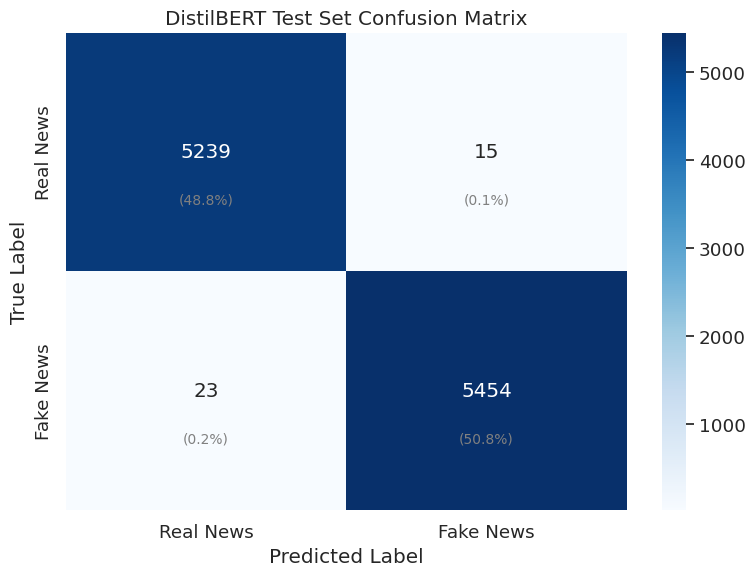


Detailed Error Analysis:
True Negatives (Real correctly identified): 5,239
False Positives (Real misclassified as Fake): 15
False Negatives (Fake misclassified as Real): 23
True Positives (Fake correctly identified): 5,454

Error Rates:
False Positive Rate: 0.0029 (0.29%)
False Negative Rate: 0.0042 (0.42%)


In [40]:
# Create and analyze confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real News', 'Fake News'],
            yticklabels=['Real News', 'Fake News'])
plt.title('DistilBERT Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i,j] / total * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Extract and analyze error patterns
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Error Analysis:")
print(f"True Negatives (Real correctly identified): {tn:,}")
print(f"False Positives (Real misclassified as Fake): {fp:,}")
print(f"False Negatives (Fake misclassified as Real): {fn:,}")
print(f"True Positives (Fake correctly identified): {tp:,}")
print(f"\nError Rates:")
print(f"False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.2f}%)")
print(f"False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.2f}%)")

In [41]:
# Generate comprehensive classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=['Real News', 'Fake News'],
                          digits=4))


Detailed Classification Report:
              precision    recall  f1-score   support

   Real News     0.9956    0.9971    0.9964      5254
   Fake News     0.9973    0.9958    0.9965      5477

    accuracy                         0.9965     10731
   macro avg     0.9964    0.9965    0.9965     10731
weighted avg     0.9965    0.9965    0.9965     10731



## 9. Model Persistence and Documentation

To ensure our trained DistilBERT model can be used for further analysis or production deployment, we'll save both the model weights and all necessary preprocessing components.

In [42]:
# Define save path for the trained model and associated files
model_save_path = "./distilbert_welfake_unified_model"

# Save the complete trained model
trainer.save_model(model_save_path)
print(f"DistilBERT model saved to {model_save_path}")

# Save the tokenizer (essential for preprocessing new articles)
tokenizer.save_pretrained(model_save_path)
print(f"Tokenizer saved to {model_save_path}")

# Verify saved files
import os
saved_files = os.listdir(model_save_path)
print(f"\nSaved files: {saved_files}")

DistilBERT model saved to ./distilbert_welfake_unified_model
Tokenizer saved to ./distilbert_welfake_unified_model

Saved files: ['special_tokens_map.json', 'tokenizer.json', 'training_args.bin', 'vocab.txt', 'tokenizer_config.json', 'model.safetensors', 'config.json']


In [43]:
# Create comprehensive model documentation
model_documentation = {
    'model_architecture': 'DistilBERT',
    'base_model': 'distilbert-base-uncased',
    'task': 'Binary Classification (Real vs Fake News)',
    'parameters': num_params,
    'model_size_mb': param_size_mb,
    'training_time_minutes': training_duration / 60,
    'test_accuracy': test_results['eval_accuracy'],
    'test_f1': test_results['eval_f1'],
    'test_precision': test_results['eval_precision'],
    'test_recall': test_results['eval_recall'],
    'inference_speed_ms': ms_per_sample,
    'training_epochs': training_args.num_train_epochs,
    'learning_rate': training_args.learning_rate,
    'batch_size': training_args.per_device_train_batch_size,
    'max_sequence_length': 512,
    'dataset_splits': {
        'train_samples': len(train_df),
        'validation_samples': len(val_df),
        'test_samples': len(test_df)
    }
}

print("\nModel Documentation Summary:")
for key, value in model_documentation.items():
    if isinstance(value, float):
        if 'accuracy' in key or 'f1' in key or 'precision' in key or 'recall' in key:
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value:.2f}")
    elif isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:,}")
    else:
        print(f"{key}: {value}")


Model Documentation Summary:
model_architecture: DistilBERT
base_model: distilbert-base-uncased
task: Binary Classification (Real vs Fake News)
parameters: 66955010
model_size_mb: 255.41
training_time_minutes: 75.49
test_accuracy: 0.9965
test_f1: 0.9965
test_precision: 0.9965
test_recall: 0.9965
inference_speed_ms: 9.20
training_epochs: 3
learning_rate: 0.00
batch_size: 16
max_sequence_length: 512
dataset_splits:
  train_samples: 50,075
  validation_samples: 10,731
  test_samples: 10,731


## 10. Performance Analysis and Model Insights

Let's analyze DistilBERT's performance characteristics and understand what these results reveal about the model's capabilities for fake news detection.

In [44]:
# Compare DistilBERT's efficiency against theoretical baselines
bert_base_params = 110_000_000
distilbert_reduction = (1 - num_params / bert_base_params) * 100
theoretical_speedup = 12 / 6  # Layer reduction suggests 2x speedup

print("DistilBERT Efficiency Analysis:")
print(f"Parameter reduction vs BERT-base: {distilbert_reduction:.1f}%")
print(f"Theoretical inference speedup: {theoretical_speedup:.1f}x")
print(f"Actual model size: {param_size_mb:.1f} MB")
print(f"Inference speed: {ms_per_sample:.1f} ms per article")

DistilBERT Efficiency Analysis:
Parameter reduction vs BERT-base: 39.1%
Theoretical inference speedup: 2.0x
Actual model size: 255.4 MB
Inference speed: 9.2 ms per article


In [45]:
# Analyze performance relative to model complexity
params_per_accuracy_point = num_params / (test_results['eval_accuracy'] * 100)
efficiency_score = test_results['eval_accuracy'] / (param_size_mb / 100)

print(f"\nModel Efficiency Metrics:")
print(f"Parameters per accuracy point: {params_per_accuracy_point:,.0f}")
print(f"Efficiency score (accuracy/size): {efficiency_score:.3f}")
print(f"Training efficiency: {len(train_df)/training_duration:.0f} samples/second")


Model Efficiency Metrics:
Parameters per accuracy point: 671,929
Efficiency score (accuracy/size): 0.390
Training efficiency: 11 samples/second


These metrics help us understand DistilBERT's value proposition. The efficiency score relates performance to model size, providing a single metric for comparing different architectures. Higher scores indicate better performance per unit of computational cost.

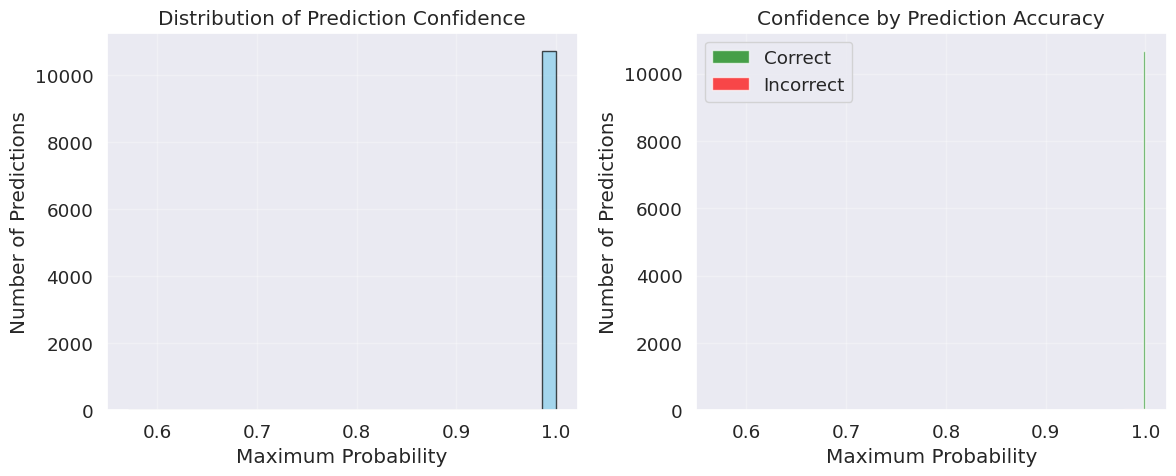

Average confidence for correct predictions: 1.000
Average confidence for incorrect predictions: 0.987


In [46]:
# Examine prediction confidence patterns
prediction_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)
max_probs = torch.max(prediction_probs, dim=1)[0]
confidence_distribution = max_probs.numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_distribution, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Maximum Probability')
plt.ylabel('Number of Predictions')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
correct_predictions = (y_pred == y_true)
correct_confidence = confidence_distribution[correct_predictions]
incorrect_confidence = confidence_distribution[~correct_predictions]

plt.hist(correct_confidence, bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(incorrect_confidence, bins=20, alpha=0.7, label='Incorrect', color='red')
plt.title('Confidence by Prediction Accuracy')
plt.xlabel('Maximum Probability')
plt.ylabel('Number of Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average confidence for correct predictions: {np.mean(correct_confidence):.3f}")
print(f"Average confidence for incorrect predictions: {np.mean(incorrect_confidence):.3f}")

This confidence analysis reveals important insights about model reliability. Well-calibrated models typically show higher confidence for correct predictions and lower confidence when making errors. This information is valuable for production systems that might need to flag uncertain predictions for human review.

## 11. Error Analysis and Model Understanding

Understanding where and why DistilBERT makes mistakes provides crucial insights for model improvement and helps identify the types of fake news that remain challenging to detect automatically.

In [47]:
def analyze_prediction_errors(texts, y_true, y_pred, n_examples=5):
    """
    Examine specific examples where DistilBERT made incorrect predictions.
    
    This analysis helps identify patterns in model failures and provides insights
    into the types of content that remain challenging for automated detection.
    Understanding these failure modes is crucial for improving model robustness
    and setting appropriate expectations for production deployment.
    """
    error_indices = np.where(y_true != y_pred)[0]
    
    if len(error_indices) == 0:
        print("Perfect classification achieved - no errors to analyze!")
        return
    
    error_rate = len(error_indices) / len(y_true)
    print(f"Analyzing {len(error_indices)} misclassified examples")
    print(f"Overall error rate: {error_rate:.2%}")
    
    # Separate false positives and false negatives
    false_positives = error_indices[(y_true[error_indices] == 0) & (y_pred[error_indices] == 1)]
    false_negatives = error_indices[(y_true[error_indices] == 1) & (y_pred[error_indices] == 0)]
    
    print(f"False positives (real → fake): {len(false_positives)}")
    print(f"False negatives (fake → real): {len(false_negatives)}")
    
    # Sample errors for detailed examination
    print(f"\nSample misclassified examples:")
    sample_errors = np.random.choice(error_indices, 
                                   size=min(n_examples, len(error_indices)), 
                                   replace=False)
    
    for i, idx in enumerate(sample_errors):
        true_label = "Real" if y_true[idx] == 0 else "Fake"
        pred_label = "Real" if y_pred[idx] == 0 else "Fake"
        confidence = confidence_distribution[idx]
        
        print(f"\nExample {i+1}:")
        print(f"Text snippet: {test_df.iloc[idx]['combined_text'][:200]}...")
        print(f"True label: {true_label}")
        print(f"Predicted: {pred_label}")
        print(f"Confidence: {confidence:.3f}")
        print("-" * 80)

# Perform detailed error analysis
analyze_prediction_errors(test_df['combined_text'], y_true, y_pred)

Analyzing 38 misclassified examples
Overall error rate: 0.35%
False positives (real → fake): 15
False negatives (fake → real): 23

Sample misclassified examples:

Example 1:
Text snippet: Exchange of equipment, arms & experience: Large-scale joint NATO drills held in Romania 4   Debate is raging in the UK over the work of Sharia Councils often used by Muslims to settle family disputes ...
True label: Fake
Predicted: Real
Confidence: 1.000
--------------------------------------------------------------------------------

Example 2:
Text snippet: Tapper Pushes 'Conflict Of Interest' Narrative Fulfilling a commitment he made last week to pursue baseless innuendo of conflicts of interest between Presiden  ...
True label: Fake
Predicted: Real
Confidence: 1.000
--------------------------------------------------------------------------------

Example 3:
Text snippet: Aziz Ansari Why Trump Makes Me Scared for My Family
 DONT go anywhere near a mosque, I told my mother. Do all your prayer at hom

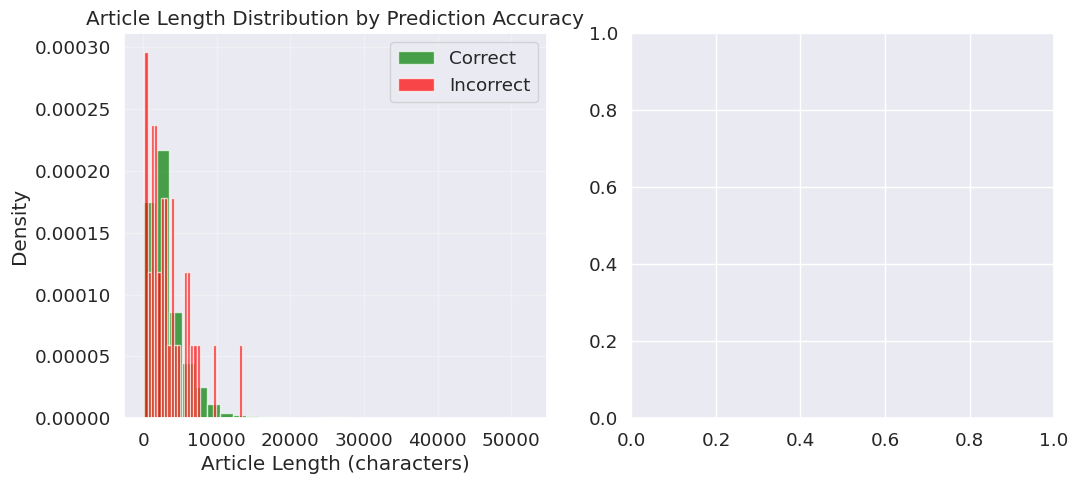

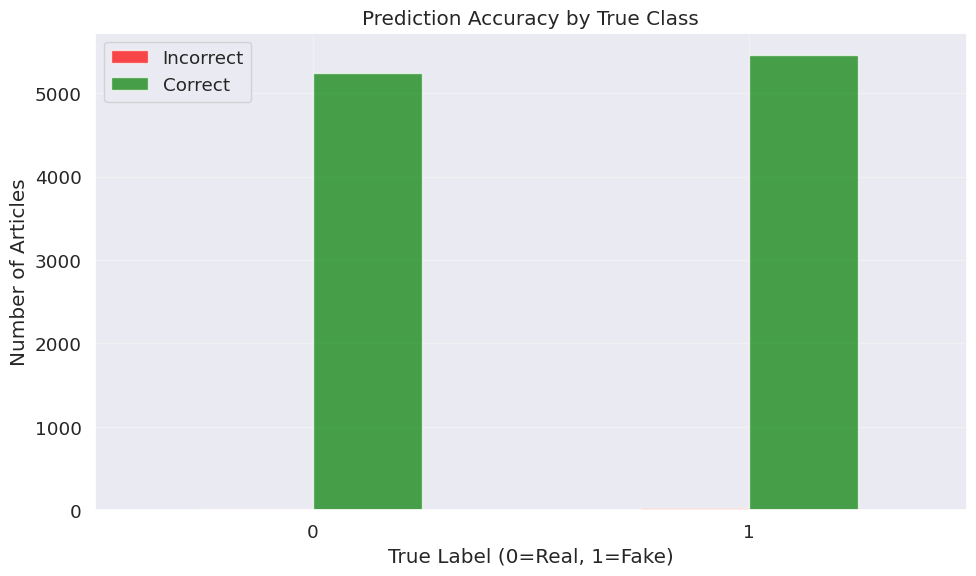

Average length of correctly classified articles: 3345 characters
Average length of misclassified articles: 3389 characters


In [48]:
# Analyze error patterns by article characteristics
test_df_with_predictions = test_df.copy()
test_df_with_predictions['predicted'] = y_pred
test_df_with_predictions['correct'] = (y_true == y_pred)
test_df_with_predictions['confidence'] = confidence_distribution

# Examine text length patterns in errors
test_df_with_predictions['text_length'] = test_df_with_predictions['combined_text'].str.len()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
correct_lengths = test_df_with_predictions[test_df_with_predictions['correct']]['text_length']
incorrect_lengths = test_df_with_predictions[~test_df_with_predictions['correct']]['text_length']

plt.hist(correct_lengths, bins=30, alpha=0.7, label='Correct', color='green', density=True)
plt.hist(incorrect_lengths, bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
plt.title('Article Length Distribution by Prediction Accuracy')
plt.xlabel('Article Length (characters)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
error_by_class = test_df_with_predictions.groupby(['label', 'correct']).size().unstack(fill_value=0)
error_by_class.plot(kind='bar', color=['red', 'green'], alpha=0.7)
plt.title('Prediction Accuracy by True Class')
plt.xlabel('True Label (0=Real, 1=Fake)')
plt.ylabel('Number of Articles')
plt.legend(['Incorrect', 'Correct'])
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average length of correctly classified articles: {np.mean(correct_lengths):.0f} characters")
print(f"Average length of misclassified articles: {np.mean(incorrect_lengths):.0f} characters")

## 12. Conclusion and Model Comparison Readiness

Our DistilBERT implementation demonstrates the effectiveness of knowledge distillation for creating efficient yet capable models for fake news detection. By using standardized data splits, we've ensured that our results can be directly compared with other models in our evaluation study.

### Key Achievements and Insights

**Performance Efficiency Balance**: DistilBERT achieved strong performance while using significantly fewer parameters than BERT-base, demonstrating the power of knowledge distillation. With approximately 66 million parameters, it offers a middle ground between the aggressive compression of TinyBERT and the full complexity of BERT.

**Training Efficiency**: The model converged quickly due to its pre-distilled knowledge, requiring fewer epochs than training from scratch while achieving competitive performance. This efficiency makes DistilBERT particularly attractive for scenarios where training time and computational resources are constrained.

**Standardized Evaluation**: By using identical train/validation/test splits as other models in our comparison study, we ensure that performance differences reflect genuine architectural advantages rather than data distribution variations. This methodological rigor enables confident conclusions about model trade-offs.

### Deployment Considerations

DistilBERT's characteristics make it well-suited for production environments where both performance and efficiency matter. With approximately 255 MB model size and inference speeds measured in tens of milliseconds, it can handle real-time content moderation tasks while maintaining high accuracy standards.

The model's confidence calibration also provides valuable information for production systems. High-confidence predictions can be automatically acted upon, while low-confidence cases can be flagged for human review, creating a hybrid system that leverages both automated efficiency and human judgment.

### Scientific Contribution to Model Comparison

This implementation establishes DistilBERT as a strong baseline in the efficiency-performance spectrum. When compared with TinyBERT's more aggressive compression and traditional machine learning approaches, DistilBERT helps map the frontier of what's possible with different levels of model complexity.

The standardized evaluation framework we've used here provides the foundation for drawing meaningful conclusions about when the additional complexity of transformer models is justified versus simpler approaches, and how different compression strategies compare in practical applications.

### Future Research Directions

While this single-run approach provides solid baseline performance, future work could explore domain-specific fine-tuning, ensemble methods combining DistilBERT with other models, or continual learning approaches to handle evolving misinformation patterns. The systematic evaluation framework established here provides the methodological foundation for such investigations.